In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import yfinance as yf
import talib
import numpy as np

# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:

def get_stock_data(ticker):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
 # Display the first few rows


In [3]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"preduction_forcaste.keras")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"preduction_forcaste.keras")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)

    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
df = get_stock_data("RELIANCE.NS")  # Replace with your stock ticker
df 

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,
Date,,,,,,,,,,,,
1996-10-04,3.621973,3.651412,3.537454,3.622922,180091079,39.823193,3.650653,3.817158,3.867230,3.886281,3.946233,3.516038
1996-10-07,3.551699,3.630520,3.428244,3.630520,272128046,36.037526,3.636788,3.803072,3.857658,3.886189,3.918297,3.505323
1996-10-08,3.566894,3.608678,3.448187,3.534606,196707309,37.422723,3.621593,3.790568,3.850517,3.886312,3.890938,3.499066
1996-10-09,3.613427,3.646664,3.556448,3.608678,175357589,41.594212,3.608393,3.775944,3.841571,3.886533,3.865850,3.499367
1996-10-10,3.710291,3.722636,3.585886,3.602980,194458201,49.187502,3.610767,3.765814,3.836044,3.887403,3.846981,3.505986
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,1285.449951,1307.699951,1282.599976,1307.699951,13713899,61.661617,1261.015002,1230.658337,1243.704998,1361.783017,1306.857558,1157.387449
2025-03-26,1273.050049,1293.800049,1268.750000,1291.000000,12074747,57.554997,1263.590002,1231.305005,1244.390999,1360.848239,1311.365001,1158.730006


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.0237 - learning_rate: 0.0010
Epoch 2/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 3/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 4/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 6/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 7/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 6.5571e-04 - learning_rate: 0.0010
Epoch 8/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 7.6581e-04 - learning_rate: 0.0010
Epoch 9/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 7.4003e-04 - learning_rate: 0.0010
Epoch 10/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 6.8816e-04 - learning_rate: 0.0010
Epoch 11/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 1

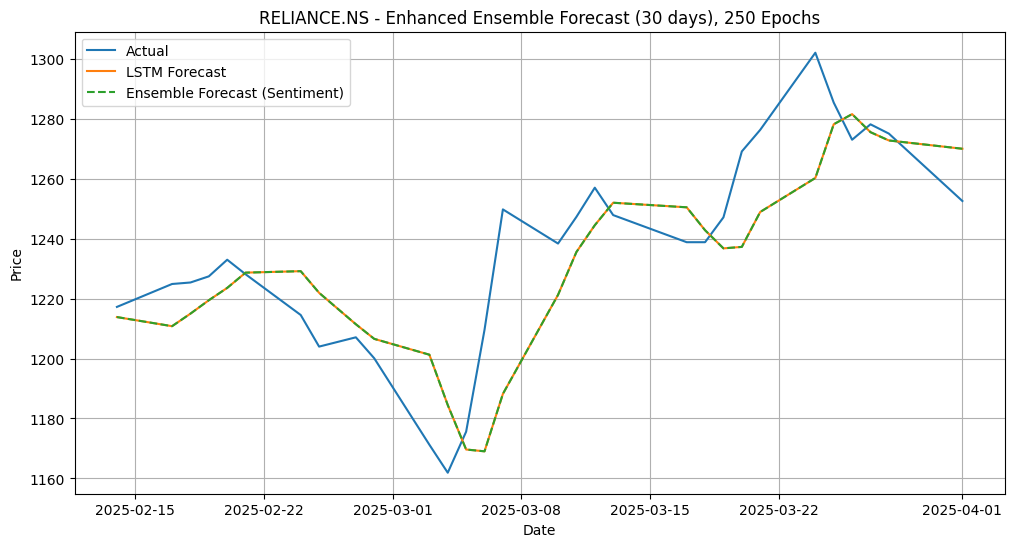

In [7]:
forecast_ensemble("RELIANCE.NS",epoch=250)

In [8]:
%pip install holidays
import holidays

from datetime import datetime, timedelta
scaler = MinMaxScaler(feature_range=(0, 1))
# Get Indian market holidays for the current year
indian_holidays = holidays.India()

def get_next_trading_day(current_date):
    next_day = current_date + timedelta(days=1)
    # Loop until the next day is not a weekend or a holiday
    while next_day.weekday() >= 5 or next_day in indian_holidays:
        next_day += timedelta(days=1)
    return next_day

def forecast_beyond_data(model, scaler, last_known_data, steps=30):
    predictions = []
    current_data = last_known_data[-60:].reshape(1, 60, 1)
    current_date = pd.to_datetime(df.index[-1])

    for _ in range(steps):
        next_day = get_next_trading_day(current_date)
        # Predict the next value
        predicted_value = model.predict(current_data)[0, 0]
        # Inverse scale to get the actual value
        predicted_value = scaler.inverse_transform([[predicted_value]])[0, 0]
        predictions.append((next_day.strftime('%Y-%m-%d'), predicted_value))

        # Prepare the next input by appending the new prediction
        scaled_prediction = scaler.transform([[predicted_value]])
        current_data = np.append(current_data[:, 1:, :], [[scaled_prediction]], axis=1)
        current_date = next_day

    forecast_df = pd.DataFrame(predictions, columns=['Date', 'Forecasted_Close'])
    return forecast_df

# Example Usage
model = load_model("preduction_forcaste.keras")
last_known_data = df[['Close']].values
forecast_df = forecast_beyond_data(model, scaler, last_known_data)
forecast_df



   ---------------------------------------- 0.0/863.9 kB ? eta -:--:--
   --------------------------------------- 863.9/863.9 kB 19.4 MB/s eta 0:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.